In [1]:
import operator
import math
import random

import numpy as np
from scipy import linalg

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import pickle
from datetime import datetime


from evaluate_fixed import Collocation2D,Collocation3D, Circle, StarLikeCurve, Sphere, StarLikeSurface, BoundaryCondition, MFSHelper2D, MFSHelper3D


# General configuration

In [2]:
DIM_2D = True # 2D - True, 3D - False

In [3]:
N = 256 # number of collocation points to calculate boundary data
Nstep = 4 # specify division step.
assert N % Nstep == 0

In [4]:
G1_DIRICHLET_COND = BoundaryCondition(lambda X: np.zeros(shape=(X.shape[1],1), dtype=float)) ## Dirichlet condition
G2_NEUMAN_COND = BoundaryCondition(lambda X: np.ones(shape=(X.shape[1],1), dtype=float)*3) ## Neuman condition

In [5]:
EXTERIOR_BOUNDARY_RADIUS = 5

In [6]:
EPS = 1e-15

In [7]:
RAND_CONST_MIN = -10
RAND_CONST_MAX = 10

In [8]:
NOISE_LEVEL = 0.02 # 2% of noise
# TODO: add noise

### Radial function for interior boundary

In [9]:
if DIM_2D:
    R_EXACT = lambda t: 2 + math.sin(t)*(0.1 + math.cos(3*t))
#     R_EXACT = lambda t: 2*math.sqrt(math.cos(t)**2 + math.sin(t)**2/4)
else:
    R_EXACT = lambda theta, phi: 2 +  math.sqrt(4.25 + 3*math.cos(3*theta))
#     R_EXACT = lambda theta, phi: 2*math.sqrt(math.cos(2*theta)+ math.sqrt(2 - math.sin(2*theta)**2))

R_EXACT = np.vectorize(R_EXACT)

# Define test boundaries and calculate boundary values

In [10]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

### Define exterior boundary

In [11]:
if DIM_2D:
    G2_BOUNDARY = Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas)) # Values in collocation points
else:
    G2_BOUNDARY = Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points

In [12]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)

## Find the Dirichlet data on Gamma2

In [13]:
A = HELPER.form_matrix(G1_VALUES.copy()) # A = (2NxN)
b = HELPER.form_column(G1_VALUES.copy())
lambda_ = linalg.lstsq(A,b)[0]

In [14]:
G2_DIRICHLET_VALUES = HELPER.uApprox(lambda_, G2_VALUES.copy(), G1_VALUES.copy())

## Recalculate data

In [15]:
N = int(N/Nstep)

In [16]:
if DIM_2D:
    collocation = Collocation2D(N)
else:
    collocation = Collocation3D(N)

In [17]:
if DIM_2D:
    G2_BOUNDARY = Circle(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeCurve(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas))
else:
    G2_BOUNDARY = Sphere(collocation, EXTERIOR_BOUNDARY_RADIUS)
    G2_VALUES = G2_BOUNDARY()
    G1_BOUNDARY = StarLikeSurface(collocation)
    G1_VALUES = G1_BOUNDARY(R_EXACT(collocation.thetas, collocation.phis)) # Values in collocation points

In [18]:
if DIM_2D:
    HELPER = MFSHelper2D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]
else:
    HELPER = MFSHelper3D(collocation, G2_BOUNDARY, G1_DIRICHLET_COND, G2_NEUMAN_COND)
    G2_DIRICHLET_VALUES = G2_DIRICHLET_VALUES[0:len(G2_DIRICHLET_VALUES)-1:Nstep]

## Define the evaluation function

### 2D

In [19]:
def feasible2D(individual, thetas, curvature_threshold):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    ## evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))
    
    try:
#         f_vals = func_vect(thetas)*individual.scale
        f_vals = func_vect(thetas)
    except Exception as e:
        return False
    
    ## Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals[:-1]
    
    ## Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    ## Singular boundary
    if (abs(f_vals) < EPS).all(): 
        return False
    
    ## Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    ## Check if function is periodic
    if abs(f_vals[0] - f_vals[-1]) > EPS:
        return False
    
#     ## check curvature
#     g1_approx_values = G1_BOUNDARY(individual.eval_values)
#     dx_dt = np.gradient(g1_approx_values[0])
#     dy_dt = np.gradient(g1_approx_values[1])
#     ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
#     d2s_dt2 = np.gradient(ds_dt)
#     d2x_dt2 = np.gradient(dx_dt)
#     d2y_dt2 = np.gradient(dy_dt)

#     curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    
#     if (curvature > curvature_threshold).any():
#         return False
    
    return True

In [20]:
def distance2D(individual):
    """A distance function to the feasibility region."""
    return 1e3 # TODO: add not const distance function

In [21]:
def eval2D(individual):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values)

    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: # Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
        print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    individual.error_values = G2_DIRICHLET_VALUES-g2_dirichlet_approx

#     individual.last_fitness = np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N ## MSE error
    individual.last_fitness = np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)) ## L2 norm
    
    return individual.last_fitness,

# def eval2D(individual):    
#     g1_approx_values = G1_BOUNDARY(individual.eval_values)
    
#     individual.error_values = G1_VALUES - g1_approx_values
#     individual.last_fitness = linalg.norm(G1_VALUES - g1_approx_values) ## Test evaluation
    
#     return individual.last_fitness,

### 3D

In [22]:
def feasible3D(individual, thetas, phis):
    """
    Feasibility function for the individual. Returns True if feasible False
    otherwise.
    
    thetas has shape (NxN) and next structure:
    
    t0  t1  t1  ...  tn
    t0  t1  t1  ...  tn
     .   .   .  ...  .
    t0  t1  t1  ...  tn
    
    phis has shape (NxN) and next structure:
    
    p0  p0  p0  ...  p0
    p1  p1  p1  ...  p1
     .   .   .  ...  .
    pn  pn  pn  ...  pn
    
    
    """    
    # Evaluate function values
    func_vect = np.vectorize(toolbox.compile(expr=individual))

    try:
#         f_vals = func_vect(theta = thetas,phi = phis)*individual.scale
        f_vals = func_vect(theta = thetas,phi = phis)
    except:
        return False
    
    # Save calculated values to evaluate the error or distance
    individual.eval_values = f_vals
    
    # Check if all values are finite
    if not np.isfinite(f_vals).all():
        return False
    
    # Check for singular surface
    if (abs(f_vals) < EPS).all():
        return False
    
    # Interior boundary has to be inside outter boundary
    if not (abs(f_vals) < EXTERIOR_BOUNDARY_RADIUS).all():
        return False
    
    # Check if surface is closed
    
    # r(0,phi_1) = r(0,phi_2) = ... = r(0, phi_n)
    thetas_0 = f_vals[:,0]
    if not np.isclose(thetas_0, thetas_0[0], atol=EPS).all():
        return False
    
    # r(pi,phi_1) = r(pi,phi_2) = ... = r(pi, phi_n)
    thetas_pi = f_vals[:,-1]
    if not np.isclose(thetas_pi, thetas_pi[0], atol=EPS).all():
        return False    
    
    # r(thetas,0) = r(thetas,2pi)
    if not np.allclose(f_vals[0], f_vals[-1], atol=EPS):
        return False
    
    return True

In [23]:
def distance3D(individual):
    """A distance function to the feasibility region."""
    return 1e3 # TODO: add not const distance function

In [24]:
def eval3D(individual):    
    g1_approx_values = G1_BOUNDARY(individual.eval_values.diagonal()) # take digagonal values (theta_0, phi_0), ..., (theta_n,phi_n)
    
#     return linalg.norm(G1_VALUES - g1_approx_values), # Test evaluation
    
    A =HELPER.form_matrix(g1_approx_values.copy())
    b = HELPER.form_column(g1_approx_values.copy())
    
    try: ## Sometimes got an error about zero division in log in formulas. Need to check if there is any error
        lambda_ = linalg.lstsq(A,b)[0]
    except:
#         print(f"F:{individual},  vals: ",individual.eval_values)
        return 1e9,
    
    g2_dirichlet_approx = HELPER.uApprox(lambda_,HELPER.g2_coll,g1_approx_values)
    
    individual.error_values = G2_DIRICHLET_VALUES-g2_dirichlet_approx
    individual.last_fitness = np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)/N ## MSE error
    
    return individual.last_fitness,
#     return linalg.norm(G2_DIRICHLET_VALUES-g2_dirichlet_approx), 
#     return np.sqrt((2*np.pi/N)*np.sum((G2_DIRICHLET_VALUES-g2_dirichlet_approx)**2)),

# Configure deap

In [25]:
def protectedDiv(left, right):
    if abs(right) < 1e-5:
        return 1.0
    return operator.truediv(left, right)

In [26]:
def protectedSqrt(val):
    return math.sqrt(abs(val))

In [27]:
def pow2(val):
    return math.pow(val,2)

def pow3(val):
    return math.pow(val,2)

def pow4(val):
    return math.pow(val,2)

def pow5(val):
    return math.pow(val,2)

### Warning: since np.vectorize used in evaluation the exceptions in functions ( even handled) gives an error

In [28]:
if DIM_2D:
    pset = gp.PrimitiveSet("MAIN", 1) # in 2d radial function has only one parameter
else:
    pset = gp.PrimitiveSet("MAIN", 2) # in 3d radial function has two parameters (phi, theta)

# some binary operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.mul, 2)
# pset.addPrimitive(protectedPow, 2) ## TODO: check and add
# pset.addPrimitive(math.pow, 2)


# some unary operators
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(protectedSqrt, 1)

##### For test
pset.addPrimitive(pow2, 1)
pset.addPrimitive(pow3, 1)
pset.addPrimitive(pow4, 1)
pset.addPrimitive(pow5, 1)
#####

# some useful constants
pset.addTerminal(np.pi,name='pi')
pset.addTerminal(np.e,name='e')
pset.addEphemeralConstant("randUniform", lambda: random.uniform(RAND_CONST_MIN, RAND_CONST_MAX))

# rename arguments
if DIM_2D:
    pset.renameArguments(ARG0='t')
else:
    pset.renameArguments(ARG0='theta')
    pset.renameArguments(ARG1='phi')

In [29]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual",
               gp.PrimitiveTree,
               fitness=creator.FitnessMin, 
               eval_values = np.empty(N, dtype=float),
               error_values = np.empty(N, dtype=float),
               last_fitness = float,
               scale = 1.0)

In [30]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [31]:
if DIM_2D:
    toolbox.register("evaluate", eval2D)
    toolbox.register("evaluate_feasible",feasible2D, thetas = collocation.thetas_closed, curvature_threshold = 25.0)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e7))
else:
    thetas_mesh, phis_mesh = collocation.mesh_closed
    toolbox.register("evaluate", eval3D)
    toolbox.register("evaluate_feasible",feasible3D, thetas = thetas_mesh, phis = phis_mesh)
    toolbox.decorate("evaluate", tools.DeltaPenalty(toolbox.evaluate_feasible, 1e10)) 

## Custom selection operators

In [32]:
from operator import attrgetter

def selectTournamentUnique(individuals, k, tournsize,best = max, fit_attr="fitness"):
    chosen = []
    while(len(chosen) < k):
        aspirants = tools.selRandom(individuals, tournsize)
        selected_best = best(aspirants, key=attrgetter(fit_attr))
        if(selected_best not in chosen):
            chosen.append(selected_best)
    return chosen

In [33]:
toolbox.register("select_tournament", tools.selTournament, tournsize=3)
toolbox.register("select_worst", tools.selWorst)

## Custom crossover operators

In [34]:
def chooseMate(ind1, ind2, operators, probs): # operators = [(operator,prob),...]
    op = np.random.choice(operators,1,probs)[0]
    return op(ind1, ind2)

In [35]:
# def cxUniform(ind1, ind2, swapProb):
#     if len(ind1) < 2 or len(ind2) < 2:
#         # No crossover on single node tree
#         return ind1, ind2
    
#     idx1 = 1
#     idx2 = 1
#     while idx1 < len(ind1) and idx2 < len(ind2):
#         if np.random.uniform() < swapProb:
#             slice1 = ind1.searchSubtree(idx1)
#             slice2 = ind2.searchSubtree(idx2)
#             ind1[slice1], ind2[slice2] = ind2[slice2], ind1[slice1]
#         idx1+=1
#         idx2+=2
            
#     return ind1, ind2

def cxUniform(ind1, ind2, swapProb):
    if len(ind1) < 2 or len(ind2) < 2:
        # No crossover on single node tree
        return ind1, ind2
    
    stack=[]
    # append left subtrees slices
    slice1,slice2=ind1.searchSubtree(1),ind2.searchSubtree(1)
    stack.append((slice1,slice2))
    
    # Append rigth subtrees slices if both exists
    if ind1.root.arity == 2 and ind2.root.arity == 2:
        stack.append((ind1.searchSubtree(slice1.stop),ind2.searchSubtree(slice2.stop)))
        
    while stack:
        # take subtrees slices
        slice1, slice2=stack.pop()
        
        if random.random() < swapProb:
            # If arity the same just swap nodes else swap subtrees
            if ind1[slice1.start].arity == ind2[slice2.start].arity:
                ind1[slice1.start], ind2[slice2.start]=ind2[slice2.start],ind1[slice1.start]
            else:
                ind1[slice1], ind2[slice2] = ind2[slice2], ind1[slice1]
                slice1, slice2=ind1.searchSubtree(slice1.start),ind2.searchSubtree(slice2.start)
        
        # Append subtrees slices
        if ind1[slice1.start].arity == 0 or ind2[slice2.start].arity == 0:
            continue
        elif ind1[slice1.start].arity == 1 or ind2[slice2.start].arity == 1:
            stack.append((ind1.searchSubtree(slice1.start+1),ind2.searchSubtree(slice2.start+1)))
        else:
            slice1, slice2=ind1.searchSubtree(slice1.start+1),ind2.searchSubtree(slice2.start+1)
            stack.append((slice1,slice2))
            stack.append((ind1.searchSubtree(slice1.stop), ind2.searchSubtree(slice2.stop)))
        
    return ind1,ind2

In [36]:
toolbox.register("mate_one_point", gp.cxOnePoint)
toolbox.register("mate_uniform", cxUniform, swapProb = 0.25)

'''
 Crossover Operator |   Apply probability
--------------------|----------------------
 One point          |         60%
 Uniform            |         40% 

'''

toolbox.register("mate",chooseMate,
                operators = (toolbox.mate_one_point,
                             toolbox.mate_uniform),
                 probs = (0.6,0.4))

In [37]:
from functools import wraps

# def resetScaleDecorator(func):
#     @wraps(func)
#     def wrapper(*args, **kwargs):
#         ret_inds = func(*args, **kwargs)
#         for ind in ret_inds:
#             ind.scale = 1.0
#         return ret_inds

#     return wrapper

def scaleMateDecorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        ret_inds = func(*args, **kwargs)
        avg_scale = sum([ind.scale for ind in args])/len(ret_inds)
        for ind in ret_inds:
            ind.scale = avg_scale
        return ret_inds

    return wrapper

## Custom mutation operators

In [38]:
def mutScale(individual, scale):
    fit = individual.last_fitness
    
    individual.scale += np.random.uniform(-scale*fit,scale*fit)
    
    return individual,

In [39]:
def mutHoist(individual):
    '''
    This operator set randomly selected subtree as a new individual
    
    '''
    # We don't want to "shrink" the root
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    return creator.Individual(individual[slice_]),

In [40]:
def mutEphemeralByFitness(individual, scale, mode):
    ephemerals_idx = [index
                      for index, node in enumerate(individual)
                      if isinstance(node, gp.Ephemeral)]
    
    if len(ephemerals_idx) > 0:
        fit = individual.last_fitness
        if mode == 'one':
            ephemerals_idx = (random.choice(ephemerals_idx),)
        
        for i in ephemerals_idx:
            individual[i].value += np.random.uniform(-scale*fit,scale*fit)
            
    return individual,

In [41]:
def mutAddConstant(individual, pset):
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    index = random.randrange(1,len(individual)) # choose random node ( not root)
    slice_ = individual.searchSubtree(index)
    mulPrimitive = gp.Primitive(operator.mul.__name__, [object, object], object)

    individual[slice_] = [mulPrimitive] + individual[slice_] + [gp.randUniform()]# Warning: function name has to be defined in pset
    return individual,

### Apply mutate operator by specified probability

In [42]:
def chooseMutate(individual, operators,probs): # operators = [(operator,prob),...]
    op = np.random.choice(operators, p=probs)
    return op(individual)

In [43]:
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# Standart ( from 'deap' lib)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)
toolbox.register("mutate_hoist", mutHoist)

# Custom
toolbox.register("mutate_ephemeral", mutEphemeralByFitness, scale = 1e-2, mode='all')
toolbox.register("mutate_scale", mutScale, scale = 1e-2)
toolbox.register("mutate_add_const", mutAddConstant, pset=pset)

'''
  Mutation Operator |   Apply probability
--------------------|----------------------
 Uniform            |         20%
 Node replacemnet   |         20% 
 Ephemeral          |         30%
 Insert             |         10%
 Hoist              |         5%
 Add constant       |         5%
 Scale              |         10%
'''

toolbox.register("mutate",chooseMutate,
                operators = (toolbox.mutate_uniform,
                             toolbox.mutate_node_replacement,
                             toolbox.mutate_ephemeral,
                             toolbox.mutate_insert,
                             toolbox.mutate_hoist,
                             toolbox.mutate_add_const,
                             toolbox.mutate_scale),
                 probs = (0.2,0.2,0.3,0.1,0.05,0.05,0.1))
# toolbox.register("mutate",chooseMutate,
#                 operators = (toolbox.mutate_uniform,
#                              toolbox.mutate_node_replacement,
#                              toolbox.mutate_ephemeral,
#                              toolbox.mutate_insert,
#                              toolbox.mutate_hoist,
#                              toolbox.mutate_add_const,
#                              toolbox.mutate_scale),
#                  probs = (0.2,0.35,0.05,0.2,0.05,0.05,0.1))

In [44]:
# toolbox.register("expr_mut", gp.genFull, min_=1, max_=5)
# # Standart ( from 'deap' lib)
# toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
# toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
# toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)
# toolbox.register("mutate_hoist", mutHoist)

# # Custom
# toolbox.register("mutate_ephemeral", mutEphemeralByFitness, scale = 1e-2, mode='one')
# toolbox.register("mutate_scale", mutScale, scale = 1e-2)
# toolbox.register("mutate_add_const", mutAddConstant, pset=pset)

# # toolbox.register("mutate",chooseMutate,
# #                 operators = (toolbox.mutate_uniform, # agressive
# #                              toolbox.mutate_node_replacement, # a bit agressive
# #                              toolbox.mutate_ephemeral, # not agressive
# #                              toolbox.mutate_insert, # not agressive
# #                              toolbox.mutate_hoist, # agressive
# #                              toolbox.mutate_add_const, # not agressive
# #                              toolbox.mutate_scale), # not agressive
# #                  probs = (0.05, 0.1, 0.3, 0.2, 0.05, 0.2, 0.1))
# toolbox.register("mutate",chooseMutate,
#                 operators = (toolbox.mutate_uniform, # agressive
#                              toolbox.mutate_node_replacement, # a bit agressive
#                              toolbox.mutate_ephemeral, # not agressive
#                              toolbox.mutate_insert, # not agressive
#                              toolbox.mutate_hoist, # agressive
#                              toolbox.mutate_add_const,), # not agressive
#                  probs = (0.05, 0.15, 0.3, 0.25, 0.05, 0.2))


In [45]:
# toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# # Standart ( from 'deap' lib)
# toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
# toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
# toolbox.register("mutate_insert", gp.mutInsert,  pset=pset)

# # Custom
# toolbox.register("mutate_ephemeral", mutEphemeralByFitness, scale = 1e-2, mode='all')
# # toolbox.register("mutate_scale", mutScale, scale = 1e-2)
# # toolbox.register("mutate_add_const", mutAddConstant, pset=pset)
# # toolbox.register("mutate_hoist", mutHoist)

# toolbox.register("mutate",chooseMutate,
#                 operators = (toolbox.mutate_uniform,
#                              toolbox.mutate_node_replacement,
#                              toolbox.mutate_ephemeral,
#                              toolbox.mutate_insert),
#                  probs = (0.6,0.1,0.2,0.1))
# # toolbox.register("mutate",chooseMutate,
# #                 operators = (toolbox.mutate_uniform,
# #                              toolbox.mutate_node_replacement,
# #                              toolbox.mutate_ephemeral,
# #                              toolbox.mutate_insert,
# #                              toolbox.mutate_hoist,
# #                              toolbox.mutate_add_const,
# #                              toolbox.mutate_scale),
# #                  probs = (0.2,0.35,0.05,0.2,0.05,0.05,0.1))

### Specify the height limits due to stack overflow error in algorithms

In [46]:
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=25))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=25))
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=60))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=60))
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=45), scaleMateDecorator)
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=45))

# Visualization

In [47]:
from abc import ABC, abstractmethod
class PlotInteractive(ABC):
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
    @abstractmethod
    def plot_approx(self, r_approx, title):
        pass

In [48]:
class PlotInteractive2D(PlotInteractive):
    def __init__(self, fig, ax, thetas, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.x = np.cos(self.thetas)
        self.y = np.sin(self.thetas)
        
        self.curve_exact = ax.plot(r_exact_vals*self.x, r_exact_vals*self.y, 'g-')
#         self.curve_approx = ax.plot(self.x, self.y, 'b--')
#         self.curve_approx_arr = [ax.plot(self.x, self.y, 'b--') for i in range(n_plot)]
        self.curve_approx_arr = [] 

    def plot_many(self, r_approx_arr, title):
        if len(self.curve_approx_arr) == 0:
            for r_vals in r_approx_arr:
                self.curve_approx_arr.append(ax.plot(r_vals*self.x,r_vals*self.y,'--'))
        else:
            for r_vals, curve_approx in zip(r_approx_arr, self.curve_approx_arr):
                curve_approx[0].set_xdata(r_vals*self.x)
                curve_approx[0].set_ydata(r_vals*self.y)
        
        self.ax.set_title(title)
        self.fig.canvas.draw()

    def plot_approx(self, r_approx, errors, title):
        
        self.curve_approx[0].set_xdata(r_approx*self.x)
        self.curve_approx[0].set_ydata(r_approx*self.y)
#         if self.plot_errors:
#             self.scatter_error.remove()
#             self.scatter_error = ax.scatter(r_approx*self.x, r_approx*self.y, s =20, c =errors  )
#             self.fig.colorbar(self.scatter_error, ax= self.ax)

        self.ax.set_title(title)
        self.fig.canvas.draw()

In [49]:
class PlotInteractive3D(PlotInteractive):
    def __init__(self, fig, ax, thetas, phis, r_exact_vals):
        super().__init__(fig, ax)
        self.thetas = thetas
        self.phis = phis
        self.x = np.outer(np.cos(self.phis), np.sin(self.thetas))
        self.y = np.outer(np.sin(self.phis), np.sin(self.thetas))
        self.z = np.outer(np.ones(np.size(self.phis)), np.cos(self.thetas))
        self.surf_exact = ax.plot_wireframe(r_exact_vals*self.x,r_exact_vals*self.y,r_exact_vals*self.z, colors='lime')
        self.surf_approx = ax.plot_wireframe(self.x,self.y,self.z)

    def plot_approx(self, r_approx, errors, title):
        self.surf_approx.remove()
        self.surf_approx = self.ax.plot_wireframe(
            r_approx*self.x,
            r_approx*self.y,
            r_approx*self.z,
            colors='royalblue')
        self.ax.set_title(title)
        fig.canvas.draw()

In [50]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# def plot_approximation(individual, title, plot_interactive):
#     r_vals = individual.eval_values
#     errors = abs(individual.error_values)
#     if DIM_2D:
#         plot_interactive.plot_approx(np.append(r_vals,r_vals[0]),np.append(errors,errors[0]), title)
#     else:
#         plot_interactive.plot_approx(r_vals,individual.error_values, title)

%matplotlib notebook
import matplotlib.pyplot as plt
def plot_approximation(individuals, title, plot_interactive):
    r_vals_arr = [np.append(ind.eval_values,ind.eval_values[0]) for ind in individuals]
    plot_interactive.plot_many(r_vals_arr, title)

<IPython.core.display.Javascript object>


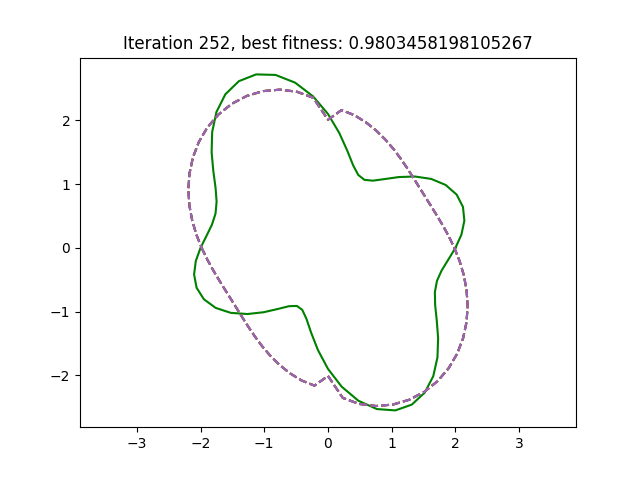

In [51]:
if DIM_2D:
    fig, ax = plt.subplots(1,1)
    ax.axis('equal')
    plt.ion()
    fig.show()
    fig.canvas.draw()
    plot_interactive_object = PlotInteractive2D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas_closed,
        r_exact_vals = R_EXACT(collocation.thetas_closed)
    )
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # TODO: set axis limits automaticly
    ax.set_xlim3d([-3, 3])
    ax.set_ylim3d([-3, 3])
    ax.set_zlim3d([-3, 3])
    plot_interactive_object = PlotInteractive3D(
        fig = fig,
        ax = ax,
        thetas = collocation.thetas,
        phis = collocation.phis_closed,
        r_exact_vals = R_EXACT(thetas_mesh, phis_mesh)
    )

%matplotlib inline
toolbox.register("plot", plot_approximation, plot_interactive = plot_interactive_object)

In [52]:
def algorithm(pop_size, gen_num,
              statistics,
              initial_guesses = None,
              checkpoint_freq = 200,
              hof_size = 5):
    
    # Insert initial guesses if given
    if(initial_guesses is None):
        population = toolbox.population(n=pop_size)
    else:
        population = toolbox.population(n=pop_size-len(initial_guesses))
        population.extend(initial_guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(hof_size)
    
    # Evaluate the entire population
    for ind in population:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)
    
    # Update hof
    hof.update(population)
    
    # Register logbook
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (statistics.fields if statistics else [])
    
    record = statistics.compile(population)
    logbook.record(gen=0, nevals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    for generation in range(1, gen_num+1):
        population = toolbox.execute_one(population)
        
        num_eval = 0
        # Evaluate the individuals with an invalid fitness
        for ind in population:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)
                num_eval +=1

        # Update hof
        hof.update(population)
        
        # Record and print progress
        record = statistics.compile(population)
        logbook.record(gen=generation, nevals=num_eval, **record)
        print(logbook.stream)
        
        # Plot current solution
        toolbox.plot(hof,title = f'Iteration {generation}, best fitness: {hof[0].fitness.values[0]}')
        
        if toolbox.stop_condition(logbook):
            break
    return population, logbook, hof

## Define execution model

In [53]:
def rModel(population, cross_prob, mut_prob, rng):
    changeSize = int(0.4*len(population))
    
    # Select parents and copy them to offspring
    parents = toolbox.select_tournament(population, changeSize)

    offspring = [toolbox.clone(ind) for ind in parents]

    # Select died elements and remove them from population
    to_die = toolbox.select_worst(population, changeSize)

    population = [ind for ind in population if not any(ind is copy for copy in to_die)]

    # Apply crossover and mutation to create offspring
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if rng.random() < cross_prob:
            ind1,ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values

    for ind in offspring:
        if rng.random() < mut_prob:
            ind, = toolbox.mutate(ind)
            del ind.fitness.values

    # Extend population by offspring
    population.extend(offspring)
    
    return population

In [54]:
def simpleModel(population, cross_prob, mut_prob, rng):    
    # Select parents and copy them to offspring
    parents = toolbox.select_tournament(population, len(population))
    offspring = [toolbox.clone(ind) for ind in parents]

    # Apply crossover and mutation to create offspring
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if rng.random() < cross_prob:
            ind1,ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values

    for ind in offspring:
        if rng.random() < mut_prob:
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
    
    return offspring

In [55]:
def muPlusLambda(population, cross_prob, mut_prob, mu, lambda_, rng):
    offspring = []
    for _ in range(lambda_):
        if rng.random() < cross_prob:
            ind1, ind2 = [toolbox.clone(i) for i in random.sample(population, 2)]
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1)
        elif rng.random() < mut_prob:
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:
            offspring.append(random.choice(population))
    population[:] = toolbox.select_tournament(population + offspring, mu)
    
    return population

In [56]:
def simpleStopCond(logbook, max_no_imporve_iters):
    fitnesses = logbook.select("min")
    
    if len(fitnesses) > max_no_imporve_iters:
        return fitnesses[-1] > fitnesses[-max_no_imporve_iters]

    return False

def deltaStopCond(logbook, max_no_imporve_iters,delta):
    fitnesses = logbook.select("min")
    
    if len(fitnesses) > max_no_imporve_iters:
        return abs(fitnesses[-1] - fitnesses[-max_no_imporve_iters]) < delta

    return False
    

In [57]:
def algorightmWithGuesses(pop_size, gen_num, guess_pop_size, guess_gen_num, stats, n_guesses):
    best_solutions = []
    
    for i in range(n_guesses):
        print(f'Guess {i+1}/{n_guesses} {"-"*100}')
        _, _, curr_hof = algorithm(pop_size = guess_pop_size, gen_num = guess_gen_num, statistics = stats)
        best_solutions.extend(curr_hof)
    
    
    return algorithm(
        pop_size = pop_size + len(best_solutions),
        gen_num = gen_num,
        statistics = stats, 
        initial_guesses = best_solutions)


In [58]:
# Define statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [59]:
toolbox.register("execute_one", rModel, cross_prob = 0.65, mut_prob = 0.25, rng = np.random.default_rng())
# toolbox.register("execute_one", simpleModel, cross_prob = 0.65, mut_prob = 0.3, rng = np.random.default_rng())
#toolbox.register("execute_one", muPlusLambda, cross_prob = 0.65, mut_prob = 0.45, mu = 1000, lambda_ = 500, rng = np.random.default_rng())

In [69]:
# toolbox.register("stop_condition", simpleStopCond, max_no_imporve_iters = 100)
toolbox.register("stop_condition", deltaStopCond, max_no_imporve_iters = 150, delta=1e-5)

In [ ]:
population, logbook, hof = algorightmWithGuesses(pop_size = 500,
                      gen_num = 500, 
                      guess_pop_size = 200,
                      guess_gen_num = 200,
                      stats = stats, 
                      n_guesses = 10)

Guess 1/10 ----------------------------------------------------------------------------------------------------
gen	nevals	avg        	std        	min    	max  
0  	200   	6.00002e+06	4.89896e+06	2.57988	1e+07
1  	58    	3.30003e+06	4.70211e+06	2.57988	1e+07
2  	54    	500036     	2.17944e+06	2.57988	1e+07
3  	64    	650018     	2.46525e+06	2.57988	1e+07
4  	63    	550011     	2.2798e+06 	2.39599	1e+07
5  	65    	900007     	2.86182e+06	2.39599	1e+07
6  	63    	600007     	2.37487e+06	2.39599	1e+07
7  	63    	650005     	2.46526e+06	2.39274	1e+07
8  	56    	600006     	2.37487e+06	2.39274	1e+07
9  	60    	650005     	2.46526e+06	2.39274	1e+07
10 	63    	750005     	2.63391e+06	2.39274	1e+07
11 	60    	650004     	2.46526e+06	2.39274	1e+07
12 	56    	650004     	2.46526e+06	2.39274	1e+07
13 	63    	750006     	2.63391e+06	2.39274	1e+07
14 	61    	600004     	2.37487e+06	2.39274	1e+07
15 	59    	600005     	2.37487e+06	2.39274	1e+07
16 	70    	800006     	2.71293e+06	2.39272	1e+07
17 	65

165	53    	300004     	1.70587e+06	2.39272	1e+07
Guess 2/10 ----------------------------------------------------------------------------------------------------
gen	nevals	avg        	std        	min    	max  
0  	200   	6.65001e+06	4.71989e+06	2.89681	1e+07
1  	59    	4.25002e+06	4.94341e+06	2.89681	1e+07
2  	57    	900030     	2.86181e+06	2.89681	1e+07
3  	60    	500016     	2.17945e+06	2.89681	1e+07
4  	57    	500010     	2.17945e+06	2.89681	1e+07
5  	68    	800009     	2.71293e+06	2.63893	1e+07
6  	65    	750008     	2.63391e+06	2.47242	1e+07
7  	62    	500007     	2.17945e+06	2.47242	1e+07
8  	65    	550005     	2.2798e+06 	2.47242	1e+07
9  	63    	500006     	2.17945e+06	2.47242	1e+07
10 	53    	600004     	2.37487e+06	2.47242	1e+07
11 	63    	250004     	1.56125e+06	2.47242	1e+07
12 	56    	300004     	1.70587e+06	2.47242	1e+07
13 	62    	350007     	1.8378e+06 	2.47242	1e+07
14 	61    	250005     	1.56125e+06	2.47242	1e+07
15 	58    	150004     	1.21552e+06	2.47242	1e+07
16 	60

159	68    	350003     	1.8378e+06 	2.39269	1e+07  
160	57    	3.34429    	3.92968    	2.39269	43.6743
161	52    	200003     	1.4e+06    	2.39269	1e+07  
162	58    	100003     	994987     	2.39269	1e+07  
163	68    	150004     	1.21552e+06	2.39269	1e+07  
164	49    	50003.4    	705337     	2.39269	1e+07  
165	58    	50004.8    	705336     	2.39269	1e+07  
166	51    	550003     	2.2798e+06 	2.39269	1e+07  
167	57    	100004     	994987     	2.39269	1e+07  
168	59    	450003     	2.07304e+06	2.39269	1e+07  
169	68    	50003.6    	705337     	2.39269	1e+07  
170	61    	50004.6    	705336     	2.39269	1e+07  
171	59    	150004     	1.21552e+06	2.39269	1e+07  
172	63    	250004     	1.56125e+06	2.39269	1e+07  
173	55    	250004     	1.56125e+06	2.39269	1e+07  
174	58    	200003     	1.4e+06    	2.39269	1e+07  
175	54    	150004     	1.21552e+06	2.39269	1e+07  
176	52    	50004.2    	705336     	2.39269	1e+07  
177	62    	250004     	1.56125e+06	2.39269	1e+07  
178	60    	200004     	1.4e+06 

122	54    	200010     	1.4e+06    	2.3927 	1e+07
123	51    	50003.3    	705337     	2.3927 	1e+07
124	52    	300003     	1.70587e+06	2.3927 	1e+07
125	61    	100007     	994987     	2.3927 	1e+07
126	51    	200003     	1.4e+06    	2.3927 	1e+07
127	55    	250007     	1.56125e+06	2.3927 	1e+07
128	53    	350006     	1.8378e+06 	2.3927 	1e+07
129	60    	100004     	994987     	2.3927 	1e+07
130	53    	300003     	1.70587e+06	2.3927 	1e+07
131	63    	300003     	1.70587e+06	2.3927 	1e+07
132	57    	300003     	1.70587e+06	2.3927 	1e+07
133	52    	200007     	1.4e+06    	2.3927 	1e+07
134	64    	250004     	1.56125e+06	2.3927 	1e+07
135	51    	250003     	1.56125e+06	2.3927 	1e+07
136	58    	3.49181    	5.58549    	2.3927 	70.8008
137	61    	350007     	1.8378e+06 	2.3927 	1e+07  
138	63    	200007     	1.4e+06    	2.3927 	1e+07  
139	60    	200004     	1.4e+06    	2.3927 	1e+07  
140	56    	450003     	2.07304e+06	2.3927 	1e+07  
141	56    	350007     	1.8378e+06 	2.3927 	1e+07  
142	51  

87 	59    	100004     	994987     	2.39271	1e+07  
88 	65    	50004.1    	705337     	2.39271	1e+07  
89 	63    	150003     	1.21552e+06	2.39271	1e+07  
90 	63    	50003.4    	705337     	2.39271	1e+07  
91 	65    	50004.1    	705337     	2.39271	1e+07  
92 	53    	3.76896    	5.05506    	2.39271	32.0225
93 	55    	100003     	994987     	2.39271	1e+07  
94 	66    	100004     	994987     	2.39271	1e+07  
95 	54    	50003.2    	705337     	2.3927 	1e+07  
96 	66    	150004     	1.21552e+06	2.3927 	1e+07  
97 	63    	4.64663    	6.10943    	2.3927 	32.0225
98 	58    	150007     	1.21552e+06	2.3927 	1e+07  
99 	53    	300004     	1.70587e+06	2.3927 	1e+07  
100	58    	50004.2    	705337     	2.3927 	1e+07  
101	52    	150004     	1.21552e+06	2.3927 	1e+07  
102	53    	50004      	705337     	2.3927 	1e+07  
103	60    	50004.1    	705337     	2.3927 	1e+07  
104	56    	150004     	1.21552e+06	2.3927 	1e+07  
105	66    	150004     	1.21552e+06	2.3927 	1e+07  
106	60    	250004     	1.56125e

46 	65    	150005     	1.21552e+06	2.39277	1e+07
47 	61    	150004     	1.21552e+06	2.39277	1e+07
48 	60    	100006     	994987     	2.39277	1e+07
49 	56    	100005     	994987     	2.39277	1e+07
50 	66    	150004     	1.21552e+06	2.39277	1e+07
51 	62    	5.39334    	10.0126    	2.39277	68.3554
52 	58    	100004     	994987     	2.39277	1e+07  
53 	68    	300006     	1.70587e+06	2.39277	1e+07  
54 	54    	250006     	1.56125e+06	2.39277	1e+07  
55 	55    	100005     	994987     	2.39277	1e+07  
56 	63    	100006     	994987     	2.39277	1e+07  
57 	60    	400005     	1.95959e+06	2.39277	1e+07  
58 	53    	100005     	994987     	2.39277	1e+07  
59 	51    	150004     	1.21552e+06	2.39277	1e+07  
60 	57    	200005     	1.4e+06    	2.39277	1e+07  
61 	58    	300005     	1.70587e+06	2.39277	1e+07  
62 	56    	100005     	994987     	2.39277	1e+07  
63 	59    	150006     	1.21552e+06	2.39277	1e+07  
64 	64    	100006     	994987     	2.39277	1e+07  
65 	53    	200004     	1.4e+06    	2.3927

4  	59    	550010     	2.2798e+06 	2.39302	1e+07
5  	54    	200007     	1.4e+06    	2.39302	1e+07
6  	51    	550005     	2.2798e+06 	2.39271	1e+07
7  	54    	400004     	1.95959e+06	2.39271	1e+07
8  	56    	150005     	1.21552e+06	2.39271	1e+07
9  	55    	250004     	1.56125e+06	2.39271	1e+07
10 	59    	100003     	994987     	2.39271	1e+07
11 	59    	150003     	1.21552e+06	2.39271	1e+07
12 	56    	150003     	1.21552e+06	2.39271	1e+07
13 	60    	350003     	1.8378e+06 	2.39271	1e+07
14 	70    	250003     	1.56125e+06	2.39271	1e+07
15 	57    	200003     	1.4e+06    	2.39271	1e+07
16 	56    	150003     	1.21552e+06	2.39271	1e+07
17 	52    	300003     	1.70587e+06	2.39271	1e+07
18 	51    	200003     	1.4e+06    	2.39271	1e+07
19 	63    	150003     	1.21552e+06	2.39271	1e+07
20 	64    	100003     	994987     	2.39271	1e+07
21 	62    	200003     	1.4e+06    	2.39271	1e+07
22 	60    	300003     	1.70587e+06	2.39271	1e+07
23 	64    	200003     	1.4e+06    	2.39271	1e+07
24 	56    	350002   

8  	59    	300006     	1.70587e+06	2.39275	1e+07
9  	64    	150006     	1.21552e+06	2.39275	1e+07
10 	65    	250005     	1.56125e+06	2.39275	1e+07
11 	51    	200005     	1.4e+06    	2.39275	1e+07
12 	60    	300004     	1.70587e+06	2.39275	1e+07
13 	67    	400005     	1.95959e+06	2.39275	1e+07
14 	55    	250004     	1.56125e+06	2.39275	1e+07
15 	66    	250004     	1.56125e+06	2.39275	1e+07
16 	64    	300005     	1.70587e+06	2.39275	1e+07
17 	53    	450004     	2.07304e+06	2.39275	1e+07
18 	66    	250008     	1.56125e+06	2.39274	1e+07
19 	53    	300004     	1.70587e+06	2.39274	1e+07
20 	59    	350003     	1.8378e+06 	2.39274	1e+07
21 	58    	250004     	1.56125e+06	2.39274	1e+07
22 	62    	300004     	1.70587e+06	2.39274	1e+07
23 	53    	350004     	1.8378e+06 	2.39274	1e+07
24 	63    	200008     	1.4e+06    	2.39274	1e+07
25 	63    	400004     	1.95959e+06	2.39274	1e+07
26 	53    	300003     	1.70587e+06	2.39274	1e+07
27 	58    	150003     	1.21552e+06	2.39274	1e+07
28 	54    	200004   

177	51    	150004     	1.21552e+06	2.39269	1e+07
178	59    	200004     	1.4e+06    	2.39269	1e+07
179	57    	200004     	1.4e+06    	2.39269	1e+07
180	62    	50004.9    	705336     	2.39269	1e+07
181	61    	450003     	2.07304e+06	2.39269	1e+07
182	61    	200004     	1.4e+06    	2.39269	1e+07
183	59    	150003     	1.21552e+06	2.39269	1e+07
Guess 8/10 ----------------------------------------------------------------------------------------------------
gen	nevals	avg        	std        	min    	max  
0  	200   	5.75002e+06	4.94341e+06	3.24766	1e+07
1  	62    	2.70003e+06	4.43958e+06	2.47449	1e+07
2  	60    	400026     	1.95959e+06	2.42221	1e+07
3  	56    	400014     	1.95959e+06	2.42221	1e+07
4  	67    	350009     	1.8378e+06 	2.39355	1e+07
5  	64    	550007     	2.2798e+06 	2.39355	1e+07
6  	65    	500005     	2.17945e+06	2.39355	1e+07
7  	66    	400005     	1.95959e+06	2.3934 	1e+07
8  	56    	200005     	1.4e+06    	2.3934 	1e+07
9  	58    	200004     	1.4e+06    	2.39303	1e+07
10 	56

152	66    	150004     	1.21552e+06	2.39269	1e+07  
153	66    	350004     	1.8378e+06 	2.39269	1e+07  
154	62    	150004     	1.21552e+06	2.39269	1e+07  
155	61    	100004     	994987     	2.39269	1e+07  
156	65    	100005     	994987     	2.39269	1e+07  
157	63    	150004     	1.21552e+06	2.39269	1e+07  
158	63    	150004     	1.21552e+06	2.39269	1e+07  
159	52    	100004     	994987     	2.39269	1e+07  
160	60    	150003     	1.21552e+06	2.39269	1e+07  
161	43    	250003     	1.56125e+06	2.39269	1e+07  
162	56    	100003     	994987     	2.39269	1e+07  
163	67    	50003.8    	705337     	2.39269	1e+07  
164	63    	100004     	994987     	2.39269	1e+07  
165	59    	100004     	994987     	2.39269	1e+07  
166	55    	300003     	1.70587e+06	2.39269	1e+07  
167	61    	150004     	1.21552e+06	2.39269	1e+07  
168	52    	50003.9    	705337     	2.39269	1e+07  
169	60    	100004     	994987     	2.39269	1e+07  
170	66    	150003     	1.21552e+06	2.39269	1e+07  
171	62    	150004     	1.21552e

133	49    	150005     	1.21552e+06	2.39269	1e+07
134	62    	200005     	1.4e+06    	2.39269	1e+07
135	60    	450003     	2.07304e+06	2.39269	1e+07
136	64    	400006     	1.95959e+06	2.39269	1e+07
137	59    	300005     	1.70587e+06	2.39269	1e+07
138	50    	300004     	1.70587e+06	2.39269	1e+07
139	56    	400005     	1.95959e+06	2.39269	1e+07
140	63    	300005     	1.70587e+06	2.39269	1e+07
141	56    	350004     	1.8378e+06 	2.39269	1e+07
142	65    	350006     	1.8378e+06 	2.39269	1e+07
143	59    	200004     	1.4e+06    	2.39269	1e+07
144	55    	400003     	1.95959e+06	2.39269	1e+07
145	63    	350006     	1.8378e+06 	2.39269	1e+07
146	55    	250005     	1.56125e+06	2.39269	1e+07
147	60    	300006     	1.70587e+06	2.39269	1e+07
148	60    	200003     	1.4e+06    	2.39269	1e+07
149	62    	450004     	2.07304e+06	2.39269	1e+07
150	55    	250006     	1.56125e+06	2.39269	1e+07
151	49    	100005     	994987     	2.39269	1e+07
152	59    	450003     	2.07304e+06	2.39269	1e+07
153	60    	150006   

125	60    	250004     	1.56125e+06	2.25081	1e+07  
126	61    	250004     	1.56125e+06	2.25081	1e+07  
127	59    	400003     	1.95959e+06	2.25081	1e+07  
128	56    	50003.7    	705337     	2.25081	1e+07  
129	68    	550005     	2.2798e+06 	2.25081	1e+07  
130	65    	300005     	1.70587e+06	2.25081	1e+07  
131	56    	600004     	2.37487e+06	2.25081	1e+07  
132	58    	450004     	2.07304e+06	2.24943	1e+07  
133	60    	300004     	1.70587e+06	2.24943	1e+07  
134	62    	350005     	1.8378e+06 	2.24943	1e+07  
135	67    	550003     	2.2798e+06 	2.24943	1e+07  
136	60    	600003     	2.37487e+06	2.24943	1e+07  
137	51    	400003     	1.95959e+06	2.24943	1e+07  
138	56    	400003     	1.95959e+06	2.24943	1e+07  
139	52    	500003     	2.17945e+06	2.24943	1e+07  
140	67    	550003     	2.2798e+06 	2.24943	1e+07  
141	60    	350005     	1.8378e+06 	2.24943	1e+07  
142	55    	350003     	1.8378e+06 	2.24936	1e+07  
143	63    	350004     	1.8378e+06 	2.24936	1e+07  
144	45    	300003     	1.70587e

D:\Study\2023\Diploma\Code\evaluate_fixed.py:392: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.module(X, Y))/(2.0*np.pi)


F:protectedSqrt(sub(sin(pow5(pow4(cos(sub(t, -2.2677240297409296))))), pow3(pow4(cos(sub(t, -2.2677240297409296)))))),  vals:  [2.85281120e-02 5.39690607e-02 9.10144527e-02 1.39351184e-01
 1.96209803e-01 2.56445360e-01 3.13292775e-01 3.59603222e-01
 3.89205706e-01 3.98048306e-01 3.84908899e-01 3.51601711e-01
 3.02669310e-01 2.44577508e-01 1.84508790e-01 1.28995298e-01
 8.27521624e-02 4.80477170e-02 2.47569500e-02 1.09906713e-02
 4.01192719e-03 1.11188128e-03 2.00918567e-04 1.66678223e-05
 1.94228961e-07 0.00000000e+00 6.36050428e-07 2.99463039e-05
 2.94987213e-04 1.47292277e-03 4.98857655e-03 1.30827439e-02
 2.85281120e-02 5.39690607e-02 9.10144527e-02 1.39351184e-01
 1.96209803e-01 2.56445360e-01 3.13292775e-01 3.59603222e-01
 3.89205706e-01 3.98048306e-01 3.84908899e-01 3.51601711e-01
 3.02669310e-01 2.44577508e-01 1.84508790e-01 1.28995298e-01
 8.27521624e-02 4.80477170e-02 2.47569500e-02 1.09906713e-02
 4.01192719e-03 1.11188128e-03 2.00918567e-04 1.66678223e-05
 1.94228961e-07 0.0

158	8     	127274     	1.12095e+06	0.980346	1e+07
159	14    	200001     	1.4e+06    	0.980346	1e+07
160	6     	72728.3    	849696     	0.980346	1e+07
161	2     	18182.8    	426014     	0.980346	1e+07
162	7     	109092     	1.03875e+06	0.980346	1e+07
163	16    	236365     	1.51913e+06	0.980346	1e+07
164	4     	54546.5    	736532     	0.980346	1e+07
165	11    	145456     	1.19724e+06	0.980346	1e+07
166	5     	72728.3    	849696     	0.980346	1e+07
167	14    	236365     	1.51913e+06	0.980346	1e+07
168	9     	127274     	1.12095e+06	0.980346	1e+07
169	9     	127274     	1.12095e+06	0.980346	1e+07
170	15    	163637     	1.26869e+06	0.980346	1e+07
171	9     	109092     	1.03875e+06	0.980346	1e+07
172	9     	127274     	1.12095e+06	0.980346	1e+07
173	5     	72728.3    	849696     	0.980346	1e+07
174	11    	127274     	1.12095e+06	0.980346	1e+07
175	14    	145456     	1.19724e+06	0.980346	1e+07
176	15    	181819     	1.33609e+06	0.980346	1e+07
177	9     	109092     	1.03875e+06	0.980346	1e+07


In [62]:
hof

In [63]:
for ind in hof:
    print(ind,'\n\n')

pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(mul(pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(pow2(protectedSqrt(mul(pow4(protectedSqrt(e)), 0.29663340377191183)))))))), 0.29663340377191183)))))) 


pow4(protectedSqrt(neg(mul(protectedSqrt(0.29663340377191183), protectedSqrt(mul(pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(pow2(protectedSqrt(mul(pow4(protectedSqrt(e)), 0.29663340377191183)))))))), 0.29663340377191183)))))) 


pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(protectedSqrt(e))), protectedSqrt(mul(pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(pow2(protectedSqrt(mul(pow4(protectedSqrt(e)), 0.29663340377191183)))))))), 0.29663340377191183)))))) 


pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(mul(pow4(protectedSqrt(neg(mul(protectedSqrt(protectedSqrt(e)), protectedSqrt(pow2(protectedSqrt(mul(pow4(protectedSqrt(0.296633403771911

In [64]:
# population, logbook, hof = algorithm(pop_size = 500, gen_num = 500, statistics = stats)

In [65]:
# population, logbook, hof = algorithm(pop_size = 200, gen_num = 100, statistics = stats, initial_guesses = hof)

In [66]:
# population, logbook, hof = algorithm(pop_size = 500, gen_num = 500, statistics = stats)

In [67]:
# population, logbook, hof = algorithm(pop_size = 500, gen_num = 500, statistics = stats, initial_guesses = hof)

In [68]:
assert False

AssertionError: 

In [ ]:
assert False

In [ ]:
def rModel(Npop, Ngen, Pcross, Pmut, rng, MaxNoImprove = 100, guesses = None, checkpointFreq = 200):    
    # Optimal coeeficient is 40% of population size.
    # See "Zbigniew Michalewicz Genetic Algorithms + Data structures = Evolutions Programs"
    changeSize = int(0.4*Npop)
    
    ## Insert initial guesses if given
    if(guesses is None):
        population = toolbox.population(n=Npop)
    else:
        population = toolbox.population(n=Npop-len(guesses))
        population.extend(guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(5)
    
    # Define statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(lambda ind: ind.height)
    
    stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size)
    
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    
    logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "max", "std"
    logbook.chapters["height"].header = "min", "avg", "max"
    
    # Evaluate the entire population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
        
    # Update hof
    hof.update(population)
    
    # Register logbook
    record = stats.compile(population)
    logbook.record(gen=0, evals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    no_improve_iter = 0
    best_fitness = 1e5
    
    for generation in range(1, Ngen):
        
        # Select parents and copy them to offspring
        parents = toolbox.select_tournament(population, changeSize)
        
        offspring = [toolbox.clone(ind) for ind in parents]
        
        # Select died elements and remove them from population
        to_die = toolbox.select_worst(population, changeSize)
        
        population = [ind for ind in population if not any(ind is copy for copy in to_die)]
        

        # Apply crossover and mutation to create offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if rng.random() < Pcross:
                ind1,ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if rng.random() < Pmut:
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
        

        # Evaluate the individuals with an invalid fitness
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalids:
            ind.fitness.values = toolbox.evaluate(ind)
        
        # Replacement of the population by the offspring
        population.extend(offspring)
        
        hof.update(population)
        
        record = stats.compile(population)
        logbook.record(gen=generation, evals=len(invalids), **record)
        
        print(logbook.stream)
                    
        # Plot current solution
        toolbox.plot(hof,title = f'Iteration {generation}, best fitness: {hof[0].fitness.values[0]}')
        
#         ## make checkpoint
#         if generation % checkpointFreq == 0:
#             now = datetime.now()
#             cp = dict(population=population, generation=generation, halloffame=hof,
#                       logbook=logbook, rndstate=rng.get_state())
#             with open(f'{now.strftime("%d-%m-%Y_%H-%M-%S")}.pkl', "wb") as cp_file:
#                 pickle.dump(cp, cp_file)
        
        if hof[0].fitness.values[0] < best_fitness:
            no_improve_iter = 0
            best_fitness = hof[0].fitness.values[0]
        else:
            no_improve_iter+=1
            
        
        if no_improve_iter > MaxNoImprove:
            break
        
    return population, logbook, hof

In [ ]:
def simpleModel(Npop, Ngen, Pcross, Pmut, rng, MaxNoImprove = 100, guesses = None, checkpointFreq = 200):
    
    ## Insert initial guesses if given
    if(guesses is None):
        population = toolbox.population(n=Npop)
    else:
        population = toolbox.population(n=Npop-len(guesses))
        population.extend(guesses)
    
    # Saves best individual
    hof = tools.HallOfFame(3)
    
    # Define statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(lambda ind: ind.height)
    
    stats = tools.MultiStatistics(fitness=stats_fit, height=stats_size)
    
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    
    logbook.header = "gen", "evals", "fitness", "height"
    logbook.chapters["fitness"].header = "min", "avg", "max", "std"
    logbook.chapters["height"].header = "min", "avg", "max"
    
    # Evaluate the entire population
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
        
    # Update hof
    hof.update(population)
    
    # Register logbook
    record = stats.compile(population)
    logbook.record(gen=0, evals=len(population), **record)
    
    # Print progress
    print(logbook.stream)
    
    no_improve_iter = 0
    best_fitness = 1e5
    
    for generation in range(1, Ngen):
        
        offspring = toolbox.select_tournament(population, len(population))
        
        offspring = [toolbox.clone(ind) for ind in offspring]        

        # Apply crossover and mutation to create offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if rng.random() < Pcross:
                ind1,ind2 = toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if rng.random() < Pmut:
                ind, = toolbox.mutate(ind)
                del ind.fitness.values
        

        # Evaluate the individuals with an invalid fitness
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalids:
            ind.fitness.values = toolbox.evaluate(ind)
        
        # Replacement of the population by the offspring
        population[:] = offspring
        
        hof.update(population)
        
        record = stats.compile(population)
        logbook.record(gen=generation, evals=len(invalids), **record)
        
        print(logbook.stream)
        # Plot current solution
        toolbox.plot(hof,title = f'Iteration {generation}, best fitness: {hof[0].fitness.values[0]}')
        if hof[0].fitness.values[0] < best_fitness:
            no_improve_iter = 0
            best_fitness = hof[0].fitness.values[0]
            
#             # Plot current solution
#             toolbox.plot(hof[0],title = f'Iteration {generation}, fitness: {hof[0].fitness.values[0]}')
        else:
            no_improve_iter+=1
            
        
        if no_improve_iter > MaxNoImprove:
            break
        
    return population, logbook, hof

In [ ]:
def guess_few(rng, n_guess = 10):
    top_selected = []
    for _ in range(n_guess):
        population, logbook, hof =  simpleModel(Npop = 200,
                                      Ngen = 500,
                                      Pcross = 0.2,
                                      Pmut = 0.8,
                                      rng = rng )
        top_selected.extend(hof)
    return top_selected

In [ ]:
random_generator = np.random.default_rng()

In [ ]:
if __name__ == "__main__":
#     population, logbook, hof = rModel(Npop = 1000,
#                                   Ngen = 300,
#                                   Pcross = 0.7,
#                                   Pmut = 0.35,
#                                   rng = random_generator,
#                                   MaxNoImprove = 100)
#     population, logbook, hof = simpleModel(Npop = 500,
#                                   Ngen = 1000,
#                                   Pcross = 0.6,
#                                   Pmut = 0.15,
#                                   rng = random_generator,
#                                   MaxNoImprove = 100)
    
    initial_guesses = guess_few(random_generator, 100)
    population, logbook, hof = simpleModel(Npop = 1000,
                                      Ngen = 500,
                                      Pcross = 0.7,
                                      Pmut = 0.35,
                                      rng = random_generator,
                                      guesses = initial_guesses,
                                     MaxNoImprove = 100)


In [ ]:
hof[0].scale

In [ ]:
print(hof[0])

In [ ]:
for e in hof:
    print(e)
    print('\n')